<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Brief-Intro" data-toc-modified-id="Brief-Intro-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Brief Intro</a></span></li><li><span><a href="#Voting-Classifiers" data-toc-modified-id="Voting-Classifiers-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Voting Classifiers</a></span><ul class="toc-item"><li><span><a href="#Hard-Voting-Classifier" data-toc-modified-id="Hard-Voting-Classifier-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Hard Voting Classifier</a></span></li><li><span><a href="#Soft-Voting-Classifier" data-toc-modified-id="Soft-Voting-Classifier-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Soft Voting Classifier</a></span></li></ul></li><li><span><a href="#Bagging-and-Pasting" data-toc-modified-id="Bagging-and-Pasting-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Bagging and Pasting</a></span></li></ul></div>

# Setup

Getting default setup from Previous Chapters:
- Making sure it works both in Python 2 & 3
- Getting common imports
- Inline plotting for Jupyter
- Save Figure Function Setup

In [1]:
# python 2 & 3 support
from __future__ import division, print_function, unicode_literals

# common imports
import numpy as np
import os

# setting random seed
np.random.seed(42)

# matplotlib inline plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# plotting setups
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


# save figure function
PROJECT_ROOT_DIR = 'figures'
CHAPTER_ID = 'ensemble_learning'
FIG_PATH = os.path.join(PROJECT_ROOT_DIR, CHAPTER_ID)

def image_path(fig_id):
    return os.path.join(FIG_PATH, fig_id)


def save_fig(fig_id, tight_layout = True):
    if not os.path.isdir(FIG_PATH):
        os.makedirs(FIG_PATH)
    fig_path = os.path.join(FIG_PATH, fig_id + '.png') # save as png file
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(fig_path, format = 'png', dpi = 300)

# Brief Intro

We will cover most popular Ensemble methods in this chapter:
- Voting
- Bagging and Pasting
- Random Forest (ensemble of Decision Trees trained primarily using Bagging)
- Boosting
- Stacking

# Voting Classifiers

## Hard Voting Classifier

A very simple/basic way to perform ensemble learning is to aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote classifier is called a _hard voting_ classifier.

![hard voting classifier](https://i.stack.imgur.com/W7UmY.png)

Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the best classifier in the ensemble. In fact, even if each classifier is a _weak learner_ (meaning it does only slightly better than random guessing), the ensemble can still be a _string learner_ (achieving high accuracy), provided there are sufficient number of weak learners and they are sufficiently diverse.

This can be illustrated via tossing a slightly biased coin that has 51% chance of coming up heads and 49% chance of coming up tails.

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000,10) < heads_proba).astype(np.int32)
coin_tosses

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 1],
       [0, 1, 1, ..., 0, 0, 1],
       ...,
       [1, 1, 0, ..., 1, 1, 0],
       [0, 0, 1, ..., 1, 1, 1],
       [0, 1, 0, ..., 0, 1, 1]], dtype=int32)

Saving figure law_of_large_numbers_plot


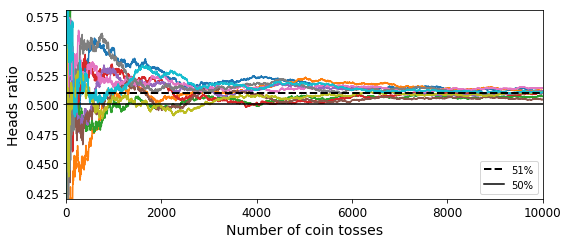

In [3]:
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0)/ np.arange(1, 10001).reshape(-1,1)

plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")

__Note__: <br>
Ensemble methods work best when the predictors are as independent from on another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble's accuracy.

Voting Classifier can be implemented via Scikit-Learn using `VotingClassifier`

----
We can illustrate this using the moon datasets:

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X,y = make_moons(n_samples = 500, noise = 0.30, random_state = 42)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

Now we import multiple classifiers and put them together using voting classifier

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state =42)
rnd_clf = RandomForestClassifier(random_state = 42)
svm_clf = SVC(random_state = 42)

voting_clf = VotingClassifier(estimators = 
                               [('lr', log_clf),
                               ('rf', rnd_clf),
                                ('svc', svm_clf)], 
                              voting = 'hard')

list_classifiers = [log_clf, rnd_clf, svm_clf, voting_clf]

Fitting them through training set & making predictions

In [6]:
# ignore future warnings for scikit learn
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFore...rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

Calculating individual classifier accuracy scores

In [7]:
from sklearn.metrics import accuracy_score

for clf in list_classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


As shown above, the voting classifier slight outperforms all the individual classifiers!

## Soft Voting Classifier

If all classifiers are able to estimate class probabilities (i.e., they have a `predict_proba()` method), then we can tell Scikit-Learn to predict the class with highest class probability, averaged over all the individual classifiers. This is called _soft voting_.

It often achieves higher performance than hard voting because it gives more weight to highly confident votes. All we need to do is to replace `voting = 'hard' ` with `voting = 'soft'` and __ensure all classifiers can estimate class probabilities__.

----
We can use the previous example to illustrate this, but we need to set `SVC(probability = True)` for SVM classifier

In [8]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFore...'rbf', max_iter=-1, probability=True, random_state=42,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [9]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


As shown above, using soft voting can get a better result than hard voting

# Bagging and Pasting